## Part II: Predicting Hall of Fame Careers

# Try the model without using cross val predict.  Split into train and test like in part I to get the model right... then figure out cross val predict.

In [332]:
# Connecting to SQLite Database
import pandas as pd
import sqlite3
conn = sqlite3.connect("lahman2016.sqlite")

In [333]:
queryMaster = 'select playerID,nameFirst,nameLast,bats,throws,debut,finalGame from Master;'
queryFielding = 'select * from Fielding;'
queryAwards = 'select playerID,awardID,yearID from AwardsPlayers;'
queryAllStar = 'select playerID, YearID from AllstarFull;'
queryHOF = '''select playerID,yearid,votedBy,needed_note from HallofFame where 
inducted == "Y" and category == "Player";'''

In [334]:
batting_df = pd.read_csv('Batting.csv')

In [335]:
master = conn.execute(queryMaster).fetchall()
master_df = pd.DataFrame(master)
fielding = conn.execute(queryFielding).fetchall()
fielding_df = pd.DataFrame(fielding)
awards = conn.execute(queryAwards).fetchall()
awards_df = pd.DataFrame(awards)
allstar = conn.execute(queryAllStar).fetchall()
allstar_df = pd.DataFrame(allstar)
hof = conn.execute(queryHOF).fetchall()
hof_df = pd.DataFrame(hof)

In [336]:
master_cols = ['playerID','nameFirst','nameLast','bats','throws','debut','finalGame']
master_df.columns = master_cols

fielding_cols = ['playerID','yearID','stint','teamID','lgID','Pos','G','GS','InnOuts','PO','A','E','DP','PB','WP','SB','CS','ZR']
fielding_df.columns = fielding_cols

awards_cols = ['playerID','awardID','yearID']
awards_df.columns = awards_cols

allstar_cols = ['playerID','YearID']
allstar_df.columns = allstar_cols

hof_cols = ['playerID','yearid','votedBy','needed_note']
hof_df.columns = hof_cols

In [337]:
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


In [338]:
player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    G = row['G']
    AB = row['AB']
    R = row['R']
    H = row['H']
    twoB = row['2B']
    threeB = row['3B']
    HR = row['HR']
    RBI = row['RBI']
    SB = row['SB']
    CS = row['CS']
    BB = row['BB']
    SO = row['SO']
    IBB = row['IBB']
    HBP = row['HBP']
    SH = row['SH']
    SF = row['SF']
    GIDP = row['GIDP']
    yearID = row['yearID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + G
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + AB
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + R
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + H
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + twoB
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + threeB
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + HR
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + RBI
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + SB
        player_stats[playerID]['CS'] = player_stats[playerID]['CS'] + CS
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + BB
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + SO
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + IBB
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + HBP
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + SH
        player_stats[playerID]['SF'] = player_stats[playerID]['SF'] + SF
        player_stats[playerID]['GIDP'] = player_stats[playerID]['GIDP'] + GIDP
        years_played[playerID].append(yearID)        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = G
        player_stats[playerID]['AB'] = AB
        player_stats[playerID]['R'] = R
        player_stats[playerID]['H'] = H
        player_stats[playerID]['2B'] = twoB
        player_stats[playerID]['3B'] = threeB
        player_stats[playerID]['HR'] = HR
        player_stats[playerID]['RBI'] = RBI
        player_stats[playerID]['SB'] = SB
        player_stats[playerID]['CS'] = CS
        player_stats[playerID]['BB'] = BB
        player_stats[playerID]['SO'] = SO
        player_stats[playerID]['IBB'] = IBB
        player_stats[playerID]['HBP'] = HBP
        player_stats[playerID]['SH'] = SH
        player_stats[playerID]['SF'] = SF
        player_stats[playerID]['GIDP'] = GIDP
        years_played[playerID] = []
        years_played[playerID].append(yearID)

In [339]:
eras_played = {}
for k, v in years_played.items():
    eras_played[k] = {}
    player_stats[k]['Years_Played'] = len(list(set(v)))
    for year in v:
        if year < 1920:
            eras_played[k]['pre1920'] = 1
        elif year >= 1920 and year <= 1941:
            eras_played[k]['1920-41'] = 1
        elif year >= 1942 and year <= 1945:
            eras_played[k]['1942-45'] = 1
        elif year >= 1946 and year <= 1962:
            eras_played[k]['1946-62'] = 1
        elif year >= 1963 and year <= 1976:
            eras_played[k]['1963-76'] = 1
        elif year >= 1977 and year <= 1992:
            eras_played[k]['1977-92'] = 1
        elif year >= 1993 and year <= 2009:
            eras_played[k]['1993-2009'] = 1

In [340]:
eras_df = pd.DataFrame.from_dict(eras_played, orient='index')

## Add in years played and eras played in.

In [341]:
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    InnOutsf = row['InnOuts']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    PBfc = row['PB']
    WPfc = row['WP']
    SBfc = row['SB']
    CSfc = row['CS']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['InnOutsf'] = player_stats[playerID]['InnOutsf'] + InnOutsf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
        player_stats[playerID]['PBfc'] = player_stats[playerID]['PBfc'] + PBfc
        player_stats[playerID]['WPfc'] = player_stats[playerID]['WPfc'] + WPfc
        player_stats[playerID]['SBfc'] = player_stats[playerID]['SBfc'] + SBfc
        player_stats[playerID]['CSfc'] = player_stats[playerID]['CSfc'] + CSfc
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['InnOutsf'] = InnOutsf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf
        player_stats[playerID]['PBfc'] = PBfc
        player_stats[playerID]['WPfc'] = WPfc
        player_stats[playerID]['SBfc'] = SBfc
        player_stats[playerID]['CSfc'] = CSfc

In [342]:
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


In [343]:
mvp_df = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy_df = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg_df = awards_df[awards_df['awardID'] == 'Gold Glove']
ss_df = awards_df[awards_df['awardID'] == 'Silver Slugger']

awards_list = [mvp_df,roy_df,gg_df,ss_df]

In [344]:
print(awards_list[1].head())

       playerID             awardID  yearID
1796  robinja02  Rookie of the Year    1947
1845   darkal01  Rookie of the Year    1948
1899  sievero01  Rookie of the Year    1949
1900  newcodo01  Rookie of the Year    1949
1953  dropowa01  Rookie of the Year    1950


In [345]:
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
lists = [mvp_list,roy_list,gg_list,ss_list]

In [346]:
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

In [347]:
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

In [348]:
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1
        player_stats[playerID]['votedBy'] = row['votedBy']

In [349]:
print(len(hof_df))
print(len(master_df))

250
19105


In [350]:
print(dict(list(player_stats.items())[0:2]))

{'finlebi01': {'AB': 44, 'CS': nan, 'RBI': 5.0, 'DPf': 1.0, 'SO': 8.0, 'GSf': nan, 'H': 8, 'Af': 10.0, 'HBP': nan, 'InnOutsf': nan, 'SB': 2.0, 'R': 2, 'POf': 29, 'SH': nan, 'IBB': nan, 'SF': nan, 'GIDP': nan, '3B': 0, '2B': 0, 'CSfc': nan, 'WPfc': nan, 'Gf': 16, 'G': 13, 'HR': 0, 'SBfc': nan, 'Years_Played': 1, 'BB': 1, 'PBfc': nan, 'Ef': 5.0}, 'burkebi02': {'AB': 22, 'CS': nan, 'RBI': 1.0, 'DPf': 0.0, 'SO': 8.0, 'GSf': nan, 'H': 5, 'Af': 11.0, 'HBP': 0.0, 'InnOutsf': nan, 'SB': 0.0, 'R': 1, 'POf': 6, 'SH': 1.0, 'IBB': nan, 'SF': nan, 'GIDP': nan, '3B': 0, '2B': 1, 'CSfc': nan, 'WPfc': nan, 'Gf': 21, 'G': 22, 'HR': 0, 'SBfc': nan, 'Years_Played': 2, 'BB': 0, 'PBfc': nan, 'Ef': 3.0}}


In [351]:
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')
stats_df['playerID'] = stats_df.index
print(stats_df.head())
print(master_df.head())

              AB    CS     RBI    DPf      SO     GSf     H     Af   HBP  \
aardsda01      4   0.0     0.0    2.0     2.0     0.0     0   29.0   0.0   
aaronha01  12364  73.0  2297.0  218.0  1383.0  2977.0  3771  429.0  32.0   
aaronto01    944   8.0    94.0  124.0   145.0   206.0   216  113.0   0.0   
aasedo01       5   0.0     0.0   10.0     3.0    91.0     0  135.0   0.0   
abadan01      21   1.0     0.0    3.0     5.0     4.0     2    1.0   0.0   

           InnOutsf    ...      PBfc     Ef  Gold Glove  AS_games  \
aardsda01    1011.0    ...       NaN    3.0         NaN       NaN   
aaronha01   78413.0    ...       NaN  144.0         3.0      25.0   
aaronto01    6472.0    ...       NaN   22.0         NaN       NaN   
aasedo01     3328.0    ...       NaN   13.0         NaN       1.0   
abadan01      138.0    ...       NaN    1.0         NaN       NaN   

           Rookie of the Year  Most Valuable Player  HoF  votedBy  \
aardsda01                 NaN                   NaN  NaN   

In [352]:
master_df = master_df.join(stats_df,on='playerID',how='inner',rsuffix='mstr')

In [353]:
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0
        
master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

In [354]:
pos_list = []
pos_dict = {}
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    games = row['G']
    pos = row['Pos']
    if playerID in pos_dict:
        if pos in pos_dict[playerID]:
            pos_dict[playerID][pos] = pos_dict[playerID][pos] + games
        else:
            pos_dict[playerID][pos] = games
    else:
        pos_dict[playerID] = {}
        pos_dict[playerID][pos] = games

In [355]:
primary_pos_dict = {}
player_list = []
for k, v in pos_dict.items():
    playerID = k
    primary_pos_dict[playerID] = {}
    primary_pos_dict[playerID]['game_count'] = 0
    primary_pos_dict[playerID]['game_count2'] = 0
    primary_pos_dict[playerID]['pos'] = ''
    for key, val in v.items():      
        if val > primary_pos_dict[playerID]['game_count']:
            primary_pos_dict[playerID]['pos2'] = primary_pos_dict[playerID]['pos']
            primary_pos_dict[playerID]['pos'] = key
            primary_pos_dict[playerID]['game_count2'] = primary_pos_dict[playerID]['game_count']
            primary_pos_dict[playerID]['game_count'] = val

In [356]:
primary_pos_df = pd.DataFrame.from_dict(primary_pos_dict, orient='index')
primary_pos_df = primary_pos_df.drop(['game_count','game_count2'], axis=1)
primary_pos_df = primary_pos_df[(primary_pos_df['pos'] != 'P') & (primary_pos_df['pos'] != 'C')]
master_df = master_df.join(primary_pos_df,on='playerID',how='right')

In [357]:
dummy_df = pd.get_dummies(master_df['pos'], prefix='pos_')
master_df = pd.concat([master_df, dummy_df], axis=1)

In [358]:
master_df['votedBy'] = master_df['votedBy'].fillna('None')
master_df = master_df[(master_df['votedBy'] == 'None') | (master_df['votedBy'] == 'BBWAA') | (master_df['votedBy'] == 'Run Off')]

In [359]:
print(master_df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'bats', 'throws', 'debut',
       'finalGame', 'AB', 'CS', 'RBI', 'DPf', 'SO', 'GSf', 'H', 'Af', 'HBP',
       'InnOutsf', 'SB', 'R', 'POf', 'SH', 'IBB', 'SF', 'GIDP', '3B', '2B',
       'CSfc', 'WPfc', 'Gf', 'G', 'HR', 'SBfc', 'Years_Played', 'BB', 'PBfc',
       'Ef', 'Gold Glove', 'AS_games', 'Rookie of the Year',
       'Most Valuable Player', 'HoF', 'votedBy', 'Silver Slugger',
       'playerIDmstr', 'bats_R', 'throws_R', 'pos', 'pos2', 'pos__1B',
       'pos__2B', 'pos__3B', 'pos__OF', 'pos__SS'],
      dtype='object')


In [360]:
# Eliminating unnecessary columns
df = master_df.drop(['nameFirst', 'nameLast', 'votedBy', 'CS', 'IBB', 'bats', 'throws','GIDP','GSf','Ef','CSfc', 'POf','Gf', 'Af', 'PBfc', 'WPfc','InnOutsf', 'SBfc','DPf', 'SH', 'SO','playerIDmstr', 'pos'], axis=1)

In [361]:
from datetime import datetime
df['debut'] =  pd.to_datetime(df['debut'])
df['finalGame'] = pd.to_datetime(df['finalGame'])
df['debutYear'] = pd.to_numeric(df['debut'].dt.strftime('%Y'), errors='coerce')
df['finalYear'] = pd.to_numeric(df['finalGame'].dt.strftime('%Y'), errors='coerce')
df = df.join(eras_df,on='playerID',how='inner')

In [362]:
print(df.columns)
print(df.isnull().sum(axis=0).tolist())

Index(['playerID', 'debut', 'finalGame', 'AB', 'RBI', 'H', 'HBP', 'SB', 'R',
       'SF', '3B', '2B', 'G', 'HR', 'Years_Played', 'BB', 'Gold Glove',
       'AS_games', 'Rookie of the Year', 'Most Valuable Player', 'HoF',
       'Silver Slugger', 'bats_R', 'throws_R', 'pos2', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__OF', 'pos__SS', 'debutYear', 'finalYear', 'pre1920',
       '1977-92', '1993-2009', '1946-62', '1942-45', '1963-76', '1920-41'],
      dtype='object')
[0, 2, 2, 0, 213, 0, 653, 315, 0, 4043, 0, 0, 0, 0, 0, 0, 7308, 6747, 7465, 7449, 7479, 7323, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 5161, 6114, 5818, 6503, 7064, 6492, 6265]


In [363]:
fill_cols = ['AS_games', 'Silver Slugger', 'Rookie of the Year', 'Gold Glove', 'Most Valuable Player', 'HoF',
'1977-92', 'pre1920', '1942-45', '1946-62', '1963-76', '1920-41', '1993-2009', 'HBP', 'SB', 'SF', 'RBI']

for col in fill_cols:
    df[col] = df[col].fillna(0)
    
print(df.isnull().sum(axis=0).tolist())

[0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0]


In [364]:
# Eliminating rows with null values
df = df.dropna()
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [365]:
df_hof = df[df['HoF'] == 1]
print(len(df_hof))

71


In [366]:
df['YSR'] = 2016 - df['finalYear']
df = df[df['YSR'] > 15]

In [367]:
df['AVE'] = df['H'] / df['AB']
df['OBP'] = (df['H'] + df['BB']) / (df['AB'] + df['BB'])
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + (df['H'] - df['2B'] - df['3B'] - df['HR'])) / df['AB']

In [368]:
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['OPS'] = ((df['H'] + df['BB'] + df['HBP']) / (df['AB'] + df['BB'] + df['SF'] + df['HBP'])) + ((single + double + triple + hr)/ df['AB'])

In [369]:
print(df.head())

    playerID      debut  finalGame     AB     RBI     H   HBP     SB     R  \
1  aaronha01 1954-04-13 1976-10-03  12364  2297.0  3771  32.0  240.0  2174   
2  aaronto01 1962-04-10 1971-09-26    944    94.0   216   0.0    9.0   102   
6  abadijo01 1875-04-26 1875-06-10     49     5.0    11   0.0    1.0     4   
7  abbated01 1897-09-04 1910-09-15   3044   324.0   772  33.0  142.0   355   
9  abbeych01 1893-08-16 1897-08-19   1751   280.0   492  23.0   93.0   307   

      SF    ...     1993-2009  1946-62  1942-45  1963-76  1920-41    YSR  \
1  121.0    ...           0.0      1.0      0.0      1.0      0.0   40.0   
2    6.0    ...           0.0      1.0      0.0      1.0      0.0   45.0   
6    0.0    ...           0.0      0.0      0.0      0.0      0.0  141.0   
7    0.0    ...           0.0      0.0      0.0      0.0      0.0  106.0   
9    0.0    ...           0.0      0.0      0.0      0.0      0.0  119.0   

        AVE       OBP  Slug_Percent       OPS  
1  0.304998  0.375781     

In [370]:
df_hitters = df
df_hitters = df_hitters[(df_hitters['playerID'] != 'johnswa01') & (df_hitters['playerID'] != 'lemonbo01') & 
(df_hitters['playerID'] != 'lyonste01') & (df_hitters['playerID'] != 'mathech01') & (df_hitters['playerID'] != 'ruffire01') &
(df_hitters['playerID'] != 'alexape01') & (df_hitters['playerID'] != 'robinja02')]

In [371]:
print(len(df_hitters))

6356


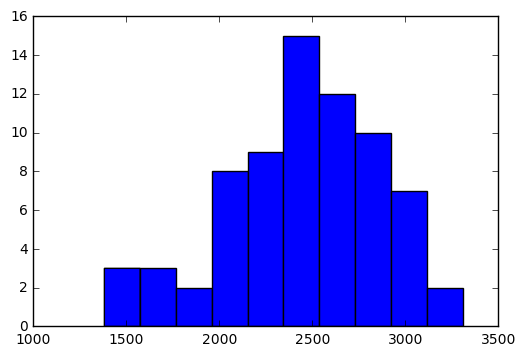

In [372]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(df_hof['G'])
plt.show()

In [373]:
print(df.columns)

Index(['playerID', 'debut', 'finalGame', 'AB', 'RBI', 'H', 'HBP', 'SB', 'R',
       'SF', '3B', '2B', 'G', 'HR', 'Years_Played', 'BB', 'Gold Glove',
       'AS_games', 'Rookie of the Year', 'Most Valuable Player', 'HoF',
       'Silver Slugger', 'bats_R', 'throws_R', 'pos2', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__OF', 'pos__SS', 'debutYear', 'finalYear', 'pre1920',
       '1977-92', '1993-2009', '1946-62', '1942-45', '1963-76', '1920-41',
       'YSR', 'AVE', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [374]:
num_cols_hitters = ['SB','R','BB', '2B', '3B','HR', 'RBI',
       'G', 'H', 'AB', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'Most Valuable Player','bats_R',
       'throws_R','pos__1B', 'pos__2B',
       'pos__3B', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920', '1920-41', '1942-45', '1946-62', '1963-76',
       '1977-92', '1993-2009', 'Years_Played', 'OBP', 'Slug_Percent', 'OPS']
data = df_hitters[num_cols_hitters]

In [375]:
print(data.columns)

Index(['SB', 'R', 'BB', '2B', '3B', 'HR', 'RBI', 'G', 'H', 'AB', 'AS_games',
       'Gold Glove', 'Rookie of the Year', 'Silver Slugger',
       'Most Valuable Player', 'bats_R', 'throws_R', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920',
       '1920-41', '1942-45', '1946-62', '1963-76', '1977-92', '1993-2009',
       'Years_Played', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [376]:
print(data.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 33, 33]


In [377]:
# Eliminating rows with null values
data = data.dropna()

In [378]:
print(len(data))

6323


In [379]:
data_hof = data[data['HoF'] == 1]
print(len(data_hof))

60


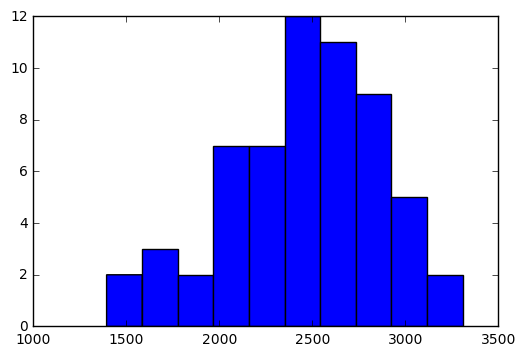

In [380]:
plt.hist(data_hof['G'])
plt.show()

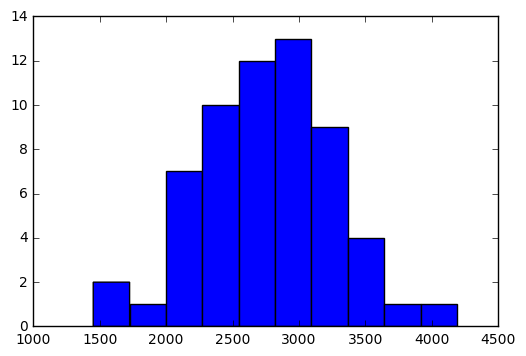

In [381]:
plt.hist(data_hof['H'])
plt.show()

In [382]:
print(data_hof[data_hof['H'] < 1500])

        SB    R    BB   2B  3B   HR     RBI     G     H    AB    ...     \
9123  22.0  971  1011  216  39  369  1015.0  1472  1451  5205    ...      

      1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  Years_Played  \
9123      0.0      0.0      1.0      0.0      0.0        0.0            10   

           OBP  Slug_Percent       OPS  
9123  0.396075      0.547935  0.946332  

[1 rows x 36 columns]


In [383]:
print(data_hof['RBI'].min())

789.0


In [384]:
print(data_hof[data_hof['G'] < 1500])

        SB     R    BB   2B  3B   HR     RBI     G     H    AB    ...     \
6624  58.0  1051   852  379  71  331  1276.0  1394  1628  5193    ...      
9123  22.0   971  1011  216  39  369  1015.0  1472  1451  5205    ...      

      1920-41  1942-45  1946-62  1963-76  1977-92  1993-2009  Years_Played  \
6624      1.0      1.0      1.0      0.0      0.0        0.0            13   
9123      0.0      0.0      1.0      0.0      0.0        0.0            10   

           OBP  Slug_Percent       OPS  
6624  0.410256      0.605045  1.016858  
9123  0.396075      0.547935  0.946332  

[2 rows x 36 columns]


In [385]:
print(data_hof.columns)

Index(['SB', 'R', 'BB', '2B', '3B', 'HR', 'RBI', 'G', 'H', 'AB', 'AS_games',
       'Gold Glove', 'Rookie of the Year', 'Silver Slugger',
       'Most Valuable Player', 'bats_R', 'throws_R', 'pos__1B', 'pos__2B',
       'pos__3B', 'pos__OF', 'pos__SS', 'YSR', 'AVE', 'HoF', 'pre1920',
       '1920-41', '1942-45', '1946-62', '1963-76', '1977-92', '1993-2009',
       'Years_Played', 'OBP', 'Slug_Percent', 'OPS'],
      dtype='object')


In [386]:
print(data_hof['H'].min())

1451


In [387]:
target = data['HoF']
features = data.drop('HoF', axis=1)

In [388]:
print(len(data))

6323


## Don't forget to deal with class imbalance.

In [389]:
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')
kf = KFold(features.shape[0], random_state=1)

predictions_lr = cross_val_predict(lr, features, target, cv=kf)
predictions_lr = pd.Series(predictions_lr)

In [390]:
np_predictions_lr = predictions_lr.as_matrix()
np_target = data['HoF'].as_matrix()

In [391]:
tn_filter_lr = (np_predictions_lr == 0) & (np_target == 0)
tn_lr = len(np_predictions_lr[tn_filter_lr])

tp_filter_lr = (np_predictions_lr == 1) & (np_target == 1)
tp_lr = len(np_predictions_lr[tp_filter_lr])

fn_filter_lr = (np_predictions_lr == 0) & (np_target == 1)
fn_lr = len(np_predictions_lr[fn_filter_lr])

fp_filter_lr = (np_predictions_lr == 1) & (np_target == 0)
fp_lr = len(np_predictions_lr[fp_filter_lr])

In [392]:
print(tn_lr)
print(tp_lr)
print(fn_lr)
print(fp_lr)
tnr_lr = tn_lr / (tn_lr + fp_lr)
tpr_lr = tp_lr / (tp_lr + fn_lr)
fnr_lr = fn_lr / (fn_lr + tp_lr)
fpr_lr = fp_lr / (fp_lr + tn_lr)


print(tpr_lr)
print(fpr_lr)

print(tnr_lr)
print(fnr_lr)

6219
56
4
44
0.9333333333333333
0.007025387194635159
0.9929746128053648
0.06666666666666667


In [393]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=14, min_samples_leaf=3, class_weight='balanced')
predictions_rf = cross_val_predict(rf, features, target, cv=kf)
predictions_rf = pd.Series(predictions_rf)

In [394]:
print(len(predictions_rf))
print(len(data['HoF']))

6323
6323


In [395]:
np_predictions_rf = predictions_rf.as_matrix()

In [396]:
tn_filter_rf = (np_predictions_rf == 0) & (np_target == 0)
tn_rf = len(np_predictions_rf[tn_filter_rf])

tp_filter_rf = (np_predictions_rf == 1) & (np_target == 1)
tp_rf = len(np_predictions_rf[tp_filter_rf])

fn_filter_rf = (np_predictions_rf == 0) & (np_target == 1)
fn_rf = len(np_predictions_rf[fn_filter_rf])

fp_filter_rf = (np_predictions_rf == 1) & (np_target == 0)
fp_rf = len(np_predictions_rf[fp_filter_rf])

In [397]:
print(tn_rf)
print(tp_rf)
print(fn_rf)
print(fp_rf)

6251
40
20
12


In [398]:
tnr_rf = tn_rf / (tn_rf + fp_rf)
tpr_rf = tp_rf / (tp_rf + fn_rf)
fnr_rf = fn_rf / (fn_rf + tp_rf)
fpr_rf = fp_rf / (fp_rf + tn_rf)

In [399]:
print(tpr_rf)
print(tnr_rf)
print(fpr_rf)
print(fnr_rf)

0.6666666666666666
0.9980839853105541
0.0019160146894459523
0.3333333333333333
